# Pneumonia Prediction with Convolutional Neural Network
The following is the notebook representing the code of the project. <br>
The code is commented and documented. <br>
For more information, see the README (report)/presentation of the project.

# Import libraries & define constants
Import the needed libraries and define the constant of the project.

Discriminate the runtime used:
- 0: Local
- 1: Colab
- 2: Kaggle

In [1]:
RUNTIME = 0

## Set the paths
Set the dataset and the model's parameter (model and weights) path. It can be a local or an absolute path.

In [1]:
DATASET_PATH = "../res/dataset/" # Dataset directory (containing train/val/test folders)
MODEL_PARAM_DIR = "../res/model_param/" # Directory where to load or save the model's parameter (model or weight)

In [2]:
from math import sqrt, ceil
import os
#from os import listdir
#import shutil
import matplotlib.pyplot as plt # Plotting
#from mlxtend.plotting import plot_confusion_matrix # Plot confusion matrix
#import seaborn as sns # Plotting
from sklearn.metrics import confusion_matrix, classification_report # Metrics of the architecture
import numpy as np # Scintific computing
import tensorflow as tf # Platform for Machine Learning
# Keras: Neural Networks API
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D #, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.regularizers import l1
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras import applications, Model
from keras.preprocessing import image

# LOAD = True when the task is to make prediction with/evaluate the model
# LOAD = False when the task is to train the model
LOAD = True
# LOAD_MODEL = True when the model has to be loaded
# LOAD_MODEL = False when the weights have to be loaded
LOAD_MODEL = False
# SAVE_BEST = True when the best weights have to be saved; False otherwise
SAVE_BEST = True

if RUNTIME == 1:
    DATASET_PATH = "/content/ds_unzipped/chest_xray/chest_xray/" # Set the path to the unzipped dataset
    # Save the parameters on the Google Drive filesystem
    MODEL_PARAM_DIR = "/content/drive/My Drive/Colab Notebooks/Project/res/weights/"
    LOAD = False # Main duty of Colab: training the model
elif RUNTIME == 2:
    DATASET_PATH = "../input/chest-xray-pneumonia/chest_xray/chest_xray/" # Set the path to the unzipped dataset
    MODEL_PARAM_DIR = "" # Save the parameters in the current folder
    LOAD = False # Main duty of Kaggle: training the model

# Dictionary containing the different paths for train/val/test
PATHS = {"train": DATASET_PATH+"train/", "val": DATASET_PATH+"val/", "test": DATASET_PATH+"test/"}
#path_labels = {"normal": "NORMAL/", "pneumonia": "PNEUMONIA/", "bacteria": "BACTERIA/", "virus": "VIRUS/", }

# List containing the labels of the dataset (e.g. ["normal", "pneumonia"])
LABELS = [item.lower() for item in os.listdir(PATHS["train"])]

SEED = 42 # Seed for Random Number Generation

SHUFFLE = False # The generators above returns the same batches: needed for a correct confusion matrix
# Even if the dataset is gray-level, we replicate the image over the 3 RGB channels: needed for pre-trained networks:
# those are trained on RGB images (see the input shape above)
COLOR_MODE = 'rgb'
# Only 2 classes (normal/pneumonia), binary task (needed for the generator)
CLASS_MODE = "binary" #or 'categorical'
# Parameters for the ImageDataGenerator. For more information, see: https://keras.io/preprocessing/image/
RESCALE = 1./255
ROTATION_RANGE = 15
WIDTH_SHIFT_RANGE = 0.2
HEIGHT_SHIFT_RANGE = 0.2
SHEAR_RANGE = 0.15
ZOOM_RANGE=0.2
HORIZONTAL_FLIP = True
FILL_MODE = "nearest"
INPUT_SHAPE = (256, 256, 1) # Input shape of the neural network
# Depending on the backend, the channel can be the first or the last parameter of a tuple
if tf.keras.backend.image_data_format() == 'channels_first': 
    INPUT_SHAPE = (INPUT_SHAPE[-1], INPUT_SHAPE[0], INPUT_SHAPE[1])
# Input shape representing the replicated gray-level images (1 channel) on the 3 RGB channels for pre-trained networks:
# from (256, 256, 1) to (256, 256, 3)
INPUT_SHAPE3 = INPUT_SHAPE[0:2]+(3,)
if tf.keras.backend.image_data_format() == 'channels_first':
    INPUT_SHAPE3 = (INPUT_SHAPE3[-1], INPUT_SHAPE3[0], INPUT_SHAPE3[1])

# Parameters of the Neural Network
POOL_SIZE = (2,2) # Pool size of the Convolutional Neural Network "pooling layer"
KERNEL_SIZE = (3,3) # Kernel size of the Convolutional Neural Network
ACTIVATION_HIDDEN_LAYERS = 'relu' # Activation function for the hidden layers
ACTIVATION_OUTPUT_LAYER = 'sigmoid' #or 'softmax' # Activation function of the output layer
DROPOUT = 0.5 # Dropout value to reduce overfitting
# Output neuron for the binary task: predicting the probability of the image being 
# "normal" (if the probability is smaller or equal than a threshold (<= 0.5))
# "pneumonia" (if the probability is greater than a threshold (> 0.5))
OUTPUT_NEURONS = 1 #or 3

# Parameter for compiling the model
LOSS = 'binary_crossentropy' #or 'categorical_crossentropy' # Loss function
OPTIMIZER = 'adam' # Optimizer of the gradient
METRICS = ['accuracy'] # Metrics used for evaluating the training

BATCH_SIZE = 16 # Batch size used for training/validating/testing
EPOCHS = 50 # Number of epochs to train the Neural Network

# Weights used for pre-trained network: imagenet dataset
WEIGHTS = "imagenet"

# Number of not trainable layers of the VGG16 pre-trained network
NOT_TRAINABLE = 11 # 11 for last 2 blocks, 15 for last block
# Learning rate for Stochastic Gradient Descent: little so to avoid damaging the low level weights
LR = 1e-4 
MOMENTUM = 0.9 # SGD momentum
REGULARIZER = l1(1e-3) # Regularization to improve the generalization capabilities of the Neural Network

Using TensorFlow backend.


# Load the data and set the generators
Load the images, setting up the generators.

In [3]:
# Set the seed
np.random.seed(SEED)
if RUNTIME == 1: # Compatibility (TensorFlow 2.0 and 1.5 (on Colab)) for setting the random seed
    tf.set_random_seed(SEED)
else:   
    tf.random.set_seed(SEED)

# Train and validtion ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=RESCALE, shear_range=SHEAR_RANGE, zoom_range=ZOOM_RANGE, 
                                   rotation_range=ROTATION_RANGE)
#train_datagen = ImageDataGenerator(rescale=RESCALE, rotation_range=ROTATION_RANGE, width_shift_range=WIDTH_SHIFT_RANGE, 
# height_shift_range=HEIGHT_SHIFT_RANGE, horizontal_flip=HORIZONTAL_FLIP, shear_range=SHEAR_RANGE, fill_mode=FILL_MODE)
# Test ImageDataGenerator: only rescale is done
test_datagen = ImageDataGenerator(rescale=RESCALE)

# Setup the 3 generators, reading from the corresponding directories
train_generator = train_datagen.flow_from_directory(PATHS["train"], target_size=INPUT_SHAPE3[0:2], 
                                                    batch_size=BATCH_SIZE, color_mode=COLOR_MODE, 
                                                    class_mode=CLASS_MODE, seed=SEED, shuffle=SHUFFLE)
val_generator = test_datagen.flow_from_directory(PATHS["val"], target_size=INPUT_SHAPE3[0:2], 
                                                 batch_size=BATCH_SIZE, color_mode=COLOR_MODE, 
                                                 class_mode=CLASS_MODE, seed=SEED, shuffle=SHUFFLE)
test_generator = test_datagen.flow_from_directory(PATHS["test"], target_size=INPUT_SHAPE3[0:2], 
                                                  batch_size=BATCH_SIZE, color_mode=COLOR_MODE, 
                                                  class_mode=CLASS_MODE, seed=SEED, shuffle=SHUFFLE)

# Number of images in each folder
image_count = {"train": len(train_generator.filenames), "val": len(val_generator.filenames), 
               "test": len(test_generator.filenames)}
# Number of steps per epoch
steps_per_epoch = {"train": np.ceil(image_count["train"]/BATCH_SIZE), "val": np.ceil(image_count["val"]/BATCH_SIZE), 
                   "test": np.ceil(image_count["test"]/BATCH_SIZE)}
# Number of elements for each class in the train dataset: needed to show the number of samples for each class
num_elem_for_class_train = {"normal": len(os.listdir(PATHS["train"]+"/NORMAL")), 
                            "pneumonia": len(os.listdir(PATHS["train"]+"/PNEUMONIA"))}

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Utility functions

## Show batch
Function which shows the images of a particular batch, with the corresponding label.

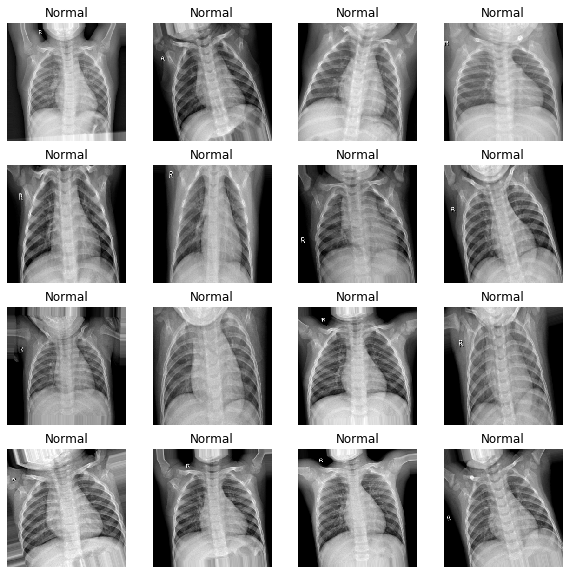

In [4]:
"""
    Shows the images of a particular batch, with the corresponding label

    Parameters
    ----------
    image_batch : array
        Array representing the batch of images
    label_batch : array
        Array representing the labels of a batch of images
    size : int
        Size of the batch
        
    Returns
    -------
    void
"""
def show_batch(image_batch, label_batch, size):
    figsize = (10,10)
    cmap = "gray"
    axis = "off"
    
    plt.figure(figsize=figsize)
    rows_cols = ceil(sqrt(size))
  
    for n in range(size):
        plt.subplot(rows_cols,rows_cols,n+1)
        plt.imshow(image_batch[n][:,:,0], cmap=cmap)
        #plt.title(LABELS[(label_batch[n]==1).tolist().index(True)]) # for multiclass
        plt.title(LABELS[0].capitalize() if label_batch[n] == 1 else LABELS[1].capitalize())
        plt.axis(axis)

# Return the batch from a generator
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch, BATCH_SIZE)

## Plot learning
Function to plot the loss and the accuracy of train and validation sets over the different epochs.

In [5]:
"""
    Function to plot the loss and the accuracy of train and validation sets over the different epochs

    Parameters
    ----------
    history : History
        History object. Its History.history attribute is a record of training loss values and metrics values 
        at successive epochs, as well as validation loss values and validation metrics values (if applicable).
        
    Returns
    -------
    void
"""
def plot_learning(name, history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.savefig(MODEL_PARAM_DIR+"acc_"+name+'.png') # Move in a folder for plots
    plt.figure()
    
    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Train and validation loss')
    plt.savefig(MODEL_PARAM_DIR+"loss_"+name+'.png')

## Load and save function
Function with the duty of loading or saving (after training) the model. <br><br>
In the function are defined several callbacks (ReduceLRONPlateau, EarlyStopping, ModelCheckpoint). <br>
At the end, a plot of the training and validation accuracy/loss is shown.

In [6]:
"""
    Function with the duty of loading or saving (after training) the model

    Parameters
    ----------
    name : str
        Name of the model
    model : Model
        Model (Keras.Sequential) of the Convolutional Neural Network
        
    Returns
    -------
    model : Model
        Compiled model after loading or saving
"""
def load_save(name, model):
    callbacks = []
    reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=1e-5,verbose=1)
    callbacks.append(reduce_learning_rate)
    
    es = EarlyStopping(patience=5)
    #callbacks.append(es)
    
    if SAVE_BEST:
        filepath = MODEL_PARAM_DIR+"model_"+NAME+"-{epoch:02d}.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
        callbacks.append(checkpoint)
        
    if LOAD:
        if LOAD_MODEL:    
            model = load_model(MODEL_PARAM_DIR+"model_"+name+'.h5')
        else:
            model.load_weights(MODEL_PARAM_DIR+"weights_"+name+'.h5')
            
        model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    else:
        model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
        history = model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCHS, 
                steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"], callbacks=callbacks)
       
        plot_learning(name, history)
        
        model.save(MODEL_PARAM_DIR+"model_"+name+'.h5')
        model.save_weights(MODEL_PARAM_DIR+"weights_"+name+'.h5')

    return model

# Model
This section is the core part of the project. Here it is defined the model of several CNN architectures:
- A simple Convolutional Neural Network
- Transfer learning with a pre-trained network
- Transfer learning with a pre-trained network and fine-tuning of top layers

The model is trained for 50 epochs.

## Simple CNN
The following architecture is composed as follows:
(Conv2D, MaxPooling2D) (x 3) -> Flatten -> Dense -> Dropout -> Dense <br><br>
Below some characteristics about the hyper-parameters (same of the constants defined above):
- Activation function
    - Hidden layers: ReLU
    - Output layer: Sigmoid
- Units
    - Hidden layers: 32/64
    - Output layer: 1
- Kernel size: (3, 3)
- Pool size: (2, 2)
- Input shape: (256, 256, 3)
- Dropout rate: 0.5 
- Regularizer: l1 with learning rate = 1e-3
- Loss function: binary_crossentropy
- Optimizer: Adam

In [7]:
NAME = "simple_regularizer" # Model name for load_save function

model = Sequential() # Sequential model

# Architecture of the CNN
model.add(Conv2D(32, KERNEL_SIZE, input_shape=INPUT_SHAPE3))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Conv2D(32, KERNEL_SIZE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Conv2D(64, KERNEL_SIZE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Flatten()) # Converts 3D feature maps to 1D feature vectors
model.add(Dense(64, activity_regularizer=REGULARIZER))
#model.add(Dense(64),
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_NEURONS))
model.add(Activation(ACTIVATION_OUTPUT_LAYER))

# Load or save the model
model = load_save(NAME, model)

# Output the validation and testing loss/accuracy
val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])
#predict = model.predict_generator(test_generator, steps=steps_per_epoch["test"])

print("Validation loss: {0:.4f}, validation accuracy: {1:.4f}".format(val_score[0], val_score[1]))
print("Test loss: {0:.4f}, test accuracy: {1:.4f}".format(test_score[0], test_score[1]))

Validation loss: 0.4633, validation accuracy: 0.8125
Test loss: 0.0902, test accuracy: 0.8894


## Transfer learning with pre-trained network (VGG16)
To improve the overall performances of the network, it is used a technique called "transfer learning", 
that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. 
<br><br> The architecture is the VGG16, trained on the "imagenet" dataset 
(for more information, see: https://neurohive.io/en/popular-networks/vgg16/). <br>
To this model, it is appended a basic CNN, that learns the features of the current dataset. <br>
The layers of the VGG16 architecture are not trainable, so to avoid damaging the weights learned.
Then, the top layers of the VGG16 architecture are made trainable, for fine-tuning purposes.

### Basic architecture
The basic CNN architecture is composed as follows:
Flatten -> Dense -> Dropout -> Dense <br><br>
Below some characteristics about the hyper-parameters (same of the constants defined above):
- Activation function
    - Hidden layers: ReLU
    - Output layer: Sigmoid
- Units
    - Hidden layers: 512
    - Output layer: 1
- Input shape: (256, 256, 3)
- Dropout rate: 0.5 
- Regularizer: l1 with learning rate = 1e-3
- Loss function: binary_crossentropy
- Optimizer: Adam

In [8]:
NAME = "vgg16_freeze2_before_regularizer" # Model name for load_save function

OPTIMIZER = SGD(lr=LR, momentum=MOMENTUM) # Optimizer

# Load the VGG16 network without including top layers
base_model = applications.VGG16(weights=WEIGHTS, include_top=False, input_shape=INPUT_SHAPE3)
 
# Define the basic CNN
headModel = base_model.output
headModel = Flatten()(headModel)
headModel = Dense(512, activation=ACTIVATION_HIDDEN_LAYERS, activity_regularizer=REGULARIZER)(headModel)
#headModel = Dense(512, activation=ACTIVATION_HIDDEN_LAYERS)(headModel)
headModel = Dropout(DROPOUT)(headModel)
headModel = Dense(OUTPUT_NEURONS, activation=ACTIVATION_OUTPUT_LAYER)(headModel)
 
# Append the basic CNN to the VGG16 architecture
model = Model(inputs=base_model.input, outputs=headModel)

# Freeze the VGG16 layers
for layer in base_model.layers:
	layer.trainable = False

# Load or save the model
model = load_save(NAME, model)

# Output the validation and testing loss/accuracy
val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print("Validation loss: {0:.4f}, validation accuracy: {1:.4f}".format(val_score[0], val_score[1]))
print("Test loss: {0:.4f}, test accuracy: {1:.4f}".format(test_score[0], test_score[1]))

Validation loss: 0.4591, validation accuracy: 0.8125
Test loss: 0.1711, test accuracy: 0.9103


### Fine-tuning of top layers
To improve the performances, the top layers of the VGG16 architecture are made trainable (only the first 11 layers are 
kept not trainable). <br> Fine-tuning should be done with a very slow learning rate, and typically with the SGD 
optimizer rather than an adaptive learning rate optimizer such as RMSProp. This is to make sure that the magnitude of 
the updates stays very small, so as not to wreck the previously learned features.

In [9]:
# Model name for load_save function
NAME = "vgg16_freeze2_after_regularizer"

# Reset the data generators
train_generator.reset()
val_generator.reset()
test_generator.reset()
 
# Make trainable the top layers, allowing the fine-tuning of these
for layer in base_model.layers[NOT_TRAINABLE:]:
	layer.trainable = True

# Load or save the model
model = load_save(NAME, model)

# Output the validation and testing loss/accuracy
val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print("Validation loss: {0:.4f}, validation accuracy: {1:.4f}".format(val_score[0], val_score[1]))
print("Test loss: {0:.4f}, test accuracy: {1:.4f}".format(test_score[0], test_score[1]))

Validation loss: 0.3227, validation accuracy: 0.8125
Test loss: 0.1286, test accuracy: 0.9311


# Confusion matrix
Print/plot the confusion matrix and the classification report on the test set.

In [10]:
# Get the true and predicted labels
true = test_generator.classes
pred = model.predict_generator(test_generator, steps=steps_per_epoch["test"])
# Set a threshold
y_pred = pred > 0.5 #or y_pred = np.argmax(pred, axis=-1)

# Get the confusion matrix
cm = confusion_matrix(true, y_pred)

# Obtain the true negatives, false positives, ...
tn, fp, fn, tp = cm.ravel()
specificity = tn/(tn+fp)
#print(specificity)

# Print the confusion matrix
print("Confusion matrix")
print(cm)
print()

# Plot the confusion matrix
#plot_confusion_matrix(cm, figsize=(15, 15), hide_ticks=True, cmap=plt.cm.Blues)
#plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
#plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
#plt.show()

# Print the classification report
print("Classification report")
print(classification_report(true, y_pred))

Confusion matrix
[[197  37]
 [  6 384]]

Classification report
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       234
           1       0.91      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624

